## Python implementation to plot Fig6  

In [1]:
import csv
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import pandas as pd

import torch
import torch.nn.functional as Func

from itertools import permutations
from torch.autograd import Variable
from torch.utils.data import DataLoader
from dataloader import *
#from graph import *
#from utils import *

In [2]:
import cv2
import torch

layer_finders = {}

def register_layer_finder(model_type):
    def register(func):
        layer_finders[model_type] = func
        return func
    return register


def visualize_cam(mask, img, alpha=1):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


@register_layer_finder('resnet')
def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


@register_layer_finder('densenet')
def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


@register_layer_finder('vgg')
def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


@register_layer_finder('alexnet')
def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


@register_layer_finder('squeezenet')
def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features_12'
            target_layer_name = 'features_12_expand3x3'
            target_layer_name = 'features_12_expand3x3_activation'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2]+'_'+hierarchy[3]]

    return target_layer


def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)


def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)

    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)

    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
class GradCAM:
    def __init__(self, arch: torch.nn.Module, target_layer: torch.nn.Module):
        self.model_arch = arch

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model_arch(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        print(score)
        #score = -score
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = torch.nn.functional.relu(saliency_map)
        saliency_map = torch.nn.functional.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


In [4]:
MODELURL = '../../checkpoint_sample/final_NK.ckpt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(nn.Linear(512, 1))

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model) 

model.load_state_dict(torch.load(MODELURL)['model'], strict = False)
model.to(device)
print("Load Finished")


# To enforce the batch normalization during the evaluation
model.eval()

Load Finished


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [5]:
config = dict(model_type='resnet', arch=model.module, layer_name='layer4')

In [6]:
cams = [GradCAM.from_config(**config)]

In [7]:
from torchvision.utils import make_grid, save_image

In [8]:
# Testing part
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

In [9]:
def gradCAM_plot(path, _mean=_mean, _std=_std):
    transform = transforms.Compose([ToTensor(), Normalize(mean=_mean, std=_std)])
    transform2 = transforms.Compose([ToTensor()])
    
    original_image = io.imread(path) / 255.0
    image = original_image.copy()
    data = transform(np.stack([image]))
    original_data = transform2(np.stack([image]))
    
    images = []
    data = data.to(device)
    original_data = original_data.to(device)
    for gradcam in cams:
        mask, _ = gradcam(data)
        heatmap, result = visualize_cam(mask, original_data)  
    
    images.extend([original_data.cpu().squeeze(), heatmap, result])
    grid_image = make_grid(images, nrow=3)
        
    return transforms.ToPILImage()(grid_image)

## Fig 6(A)  

Grad-CAM heatmap visualization over a grid image of the Ryongyon region from 2016 to 2019, indicating the reclaimed land as being a critical factor in the change of economic development scores.  

Image location : 6309_13872

### 2016 ~ 2019    

/home/lion4151/anaconda3/envs/wco_graph/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/lion4151/anaconda3/envs/wco_graph/lib/python3.7/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor(0.1967, device='cuda:0', grad_fn=<SqueezeBackward0>)


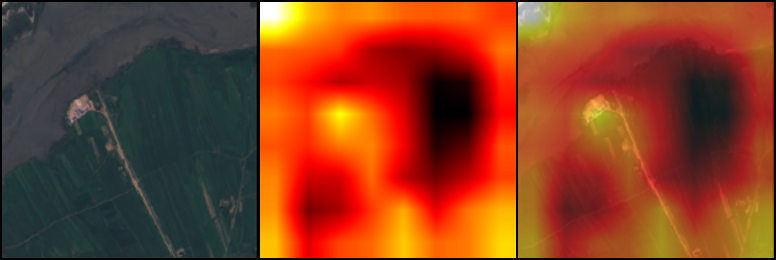

In [10]:
gradCAM_plot('./Fig6_ref/2016/6309_13872.png')

tensor(0.2665, device='cuda:0', grad_fn=<SqueezeBackward0>)


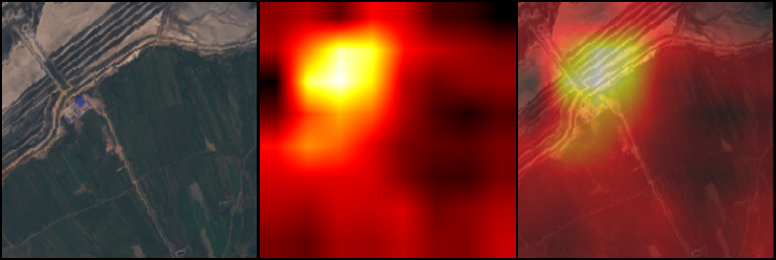

In [11]:
gradCAM_plot('./Fig6_ref/2017/6309_13872.png')

tensor(0.3353, device='cuda:0', grad_fn=<SqueezeBackward0>)


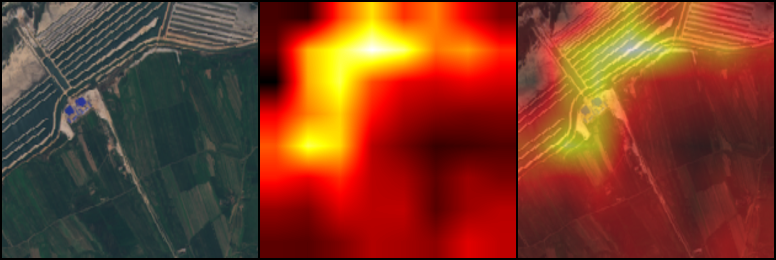

In [12]:
gradCAM_plot('./Fig6_ref/2018/6309_13872.png')

tensor(0.3062, device='cuda:0', grad_fn=<SqueezeBackward0>)


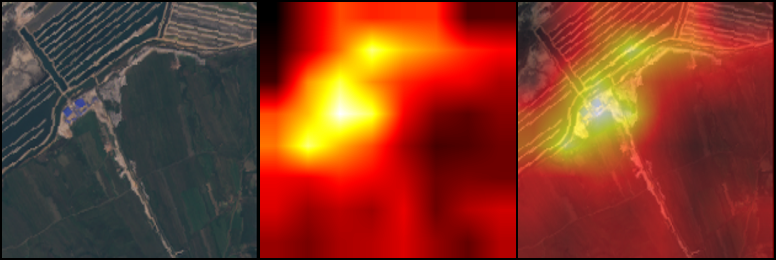

In [13]:
gradCAM_plot('./Fig6_ref/2019/6309_13872.png')

## Fig 6(B)  

Grad-CAM heatmap over three areas of interest: Samjiyon development project, Kalma tourist project, and Nyongbyun nuclear scientific research center. All three sites show growth in economic development and the heatmap highlights the key areas contributed to the score change. The model can detect subtle changes in roofing and road network in the Nyongbyun nuclear site that would be otherwise hard to detect with human eyes.

### Samjiyeon  

#### Before (2016-17) / After (2018-19)  

Image location : 6094_14031

tensor(0.4046, device='cuda:0', grad_fn=<SqueezeBackward0>)


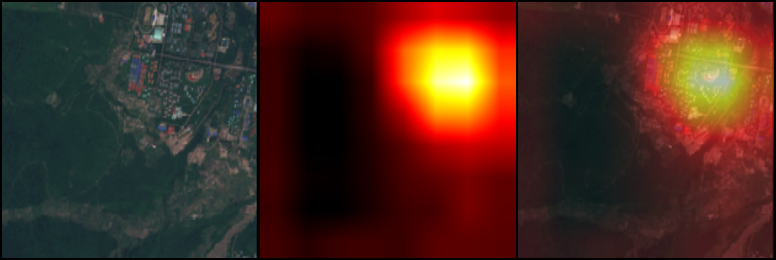

In [14]:
gradCAM_plot('./Fig6_ref/2016/6094_14031.png')

tensor(0.6088, device='cuda:0', grad_fn=<SqueezeBackward0>)


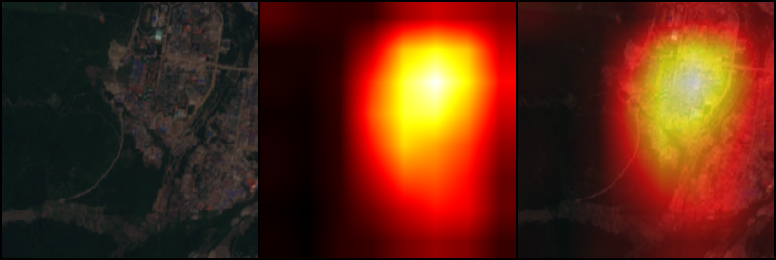

In [15]:
gradCAM_plot('./Fig5_ref/2018/6094_14031.png')

### Kalma  

#### Before (2016-17) / After (2018-19)  

Image location : 6251_13993 

tensor(0.5147, device='cuda:0', grad_fn=<SqueezeBackward0>)


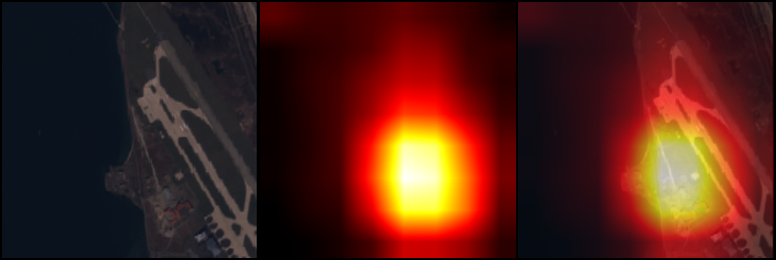

In [16]:
gradCAM_plot('./Fig6_ref/2016/6251_13993.png')

tensor(0.6846, device='cuda:0', grad_fn=<SqueezeBackward0>)


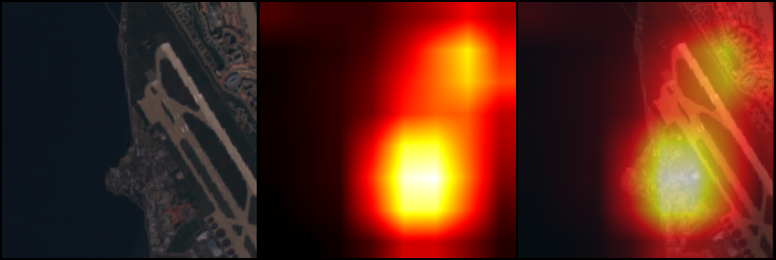

In [17]:
gradCAM_plot('./Fig6_ref/2019/6251_13993.png')

### Nyongbyun  

#### Before (2016-17) / After (2018-19)  

Image location : 6214_13915  

tensor(0.2373, device='cuda:0', grad_fn=<SqueezeBackward0>)


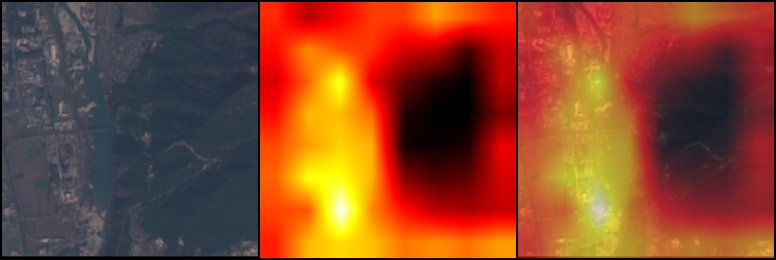

In [18]:
gradCAM_plot('./Fig5_ref/2017/6214_13915.png')

tensor(0.3581, device='cuda:0', grad_fn=<SqueezeBackward0>)


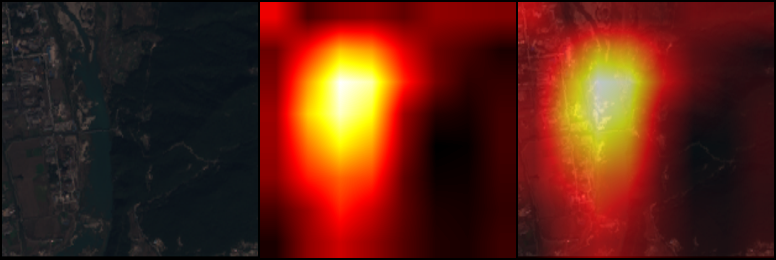

In [19]:
gradCAM_plot('./Fig6_ref/2019/6214_13915.png')